In [1]:
from helper_funcs import *

# Colourblind friendly colours
import tol_colors as tc
cset = tc.tol_cset('bright')
plt.rc('axes', prop_cycle=plt.cycler('color', list(cset)))

fsize = 24
plt.rcParams.update({'font.size': fsize})


dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

conmap = {
    '000conEC':'EMC (298$\,$K)',
    '033conEC':'EC:EMC (3:7) (298$\,$K)',
    '066conEC':'EC:EMC (7:3) (298$\,$K)',
    '100conEC':'EC (313$\,$K)',
}

In [2]:
tags = [
    'IBM23/B97/SEED1/DSET1',
    'SDN22NQ/B97/SEED1/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo

# Training error

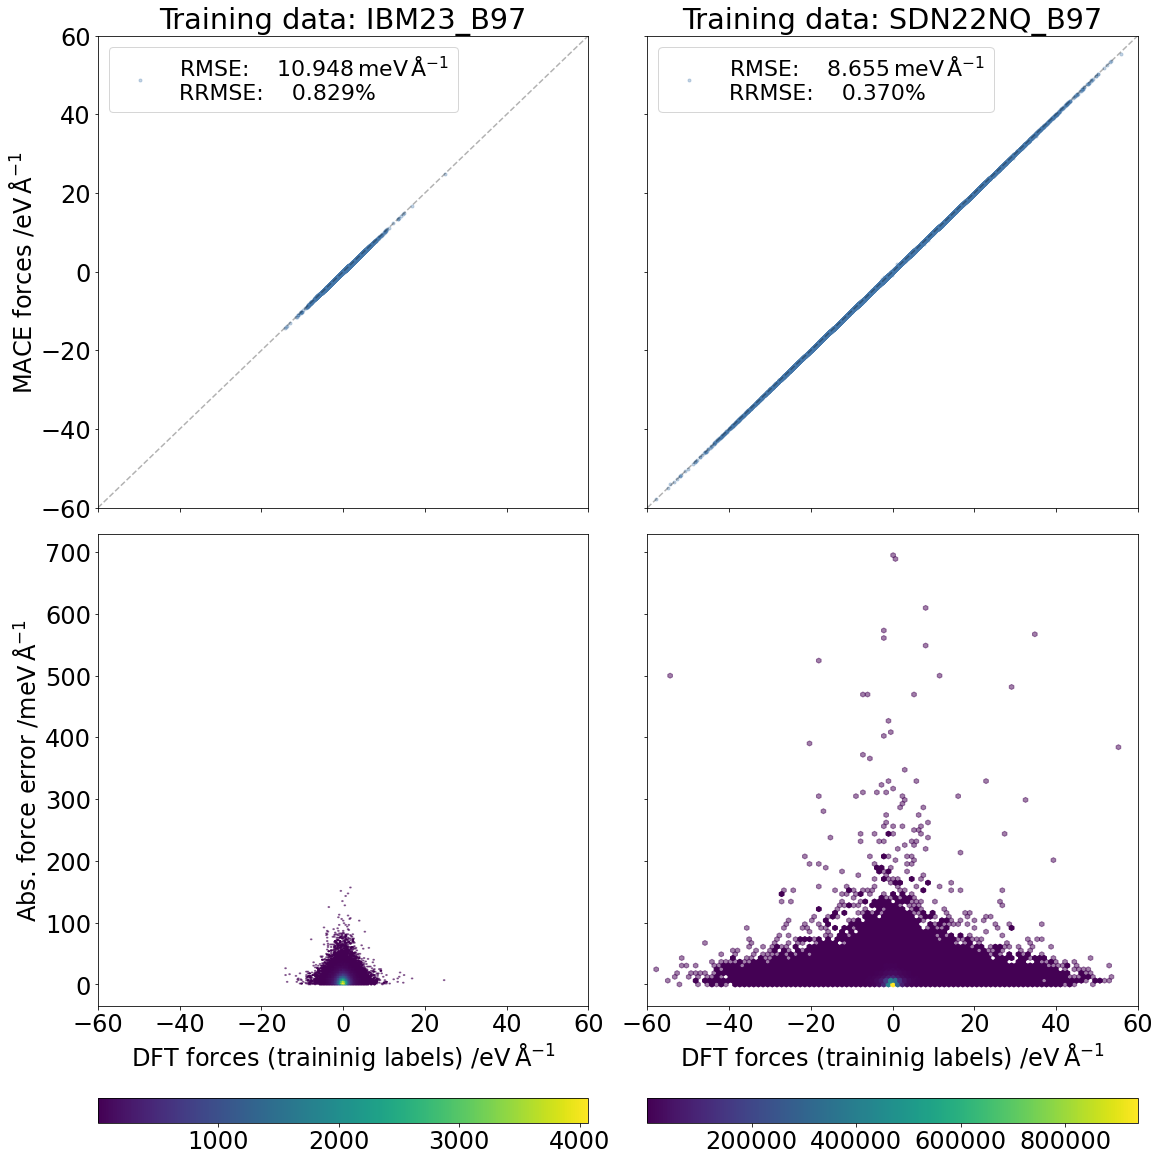

In [ ]:
fsize = 24
plt.rcParams.update({'font.size': fsize})

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}/{tag}/*') # Argument should be 'tag' to be consistent with zenodo

fig, axs = plt.subplots(2,len(tags), figsize=(8*len(tags), 8*2), sharex=True, sharey='row', layout='constrained')
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[0,i].set_title(f'Training data: {data_set}_{functional}')
    axs[0,i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV$\,$Å$^{{-1}}$\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[0,i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[0,i].plot([0, 1], [0, 1], 'k--', transform=axs[0,i].transAxes, alpha=0.3)
    axs[0,i].set_xlim([-60,60])
    axs[0,i].set_ylim([-60,60])
    if i == 0: axs[0,i].set_ylabel('MACE forces /eV$\,$Å$^{-1}$')

    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=1, alpha=0.5)
    h = axs[1,i].hexbin(ref_forces, abs(ref_forces-mace_forces)*1000, mincnt=2)
    plt.colorbar(h, ax=axs[1,i], orientation='horizontal')

    axs[1,i].set_xlabel('DFT forces (traininig labels) /eV$\,$Å$^{-1}$')
    axs[1,0].set_ylabel('Abs. force error /meV$\,$Å$^{-1}$')

## A perspective on force errors
1. Calculate the average movement of an atom during a time step
2. Integrate the force along that distance to get the potential error in terms of an energy
3. Plot the correlation and determine the RMSE of this energy

(Value for step length taken from part 1)

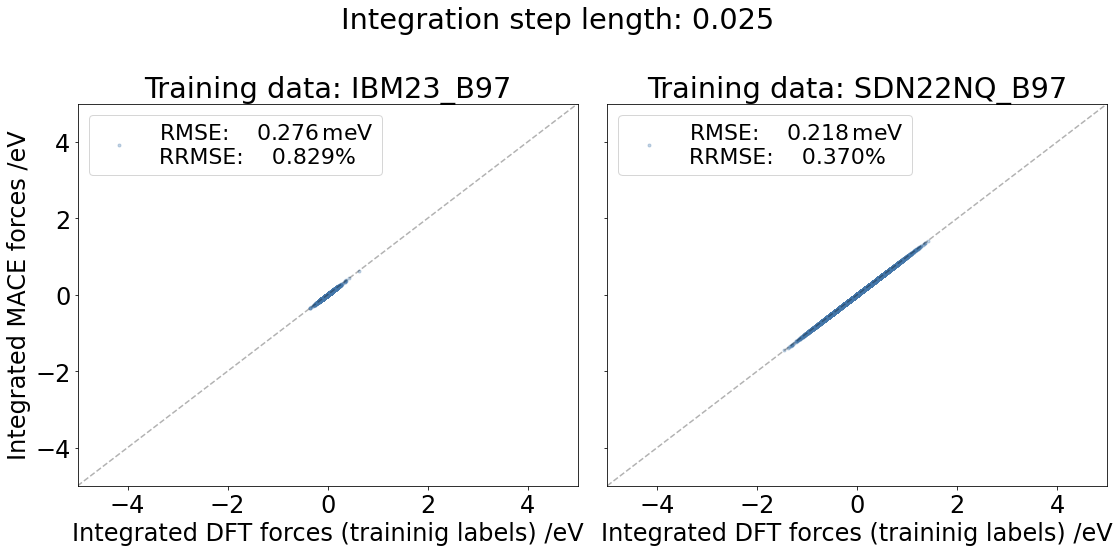

In [8]:
step_length = 0.02524

fig, axs = plt.subplots(1,len(tags), figsize=(8*len(tags), 8*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces']*step_length for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces']*step_length for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(ref_forces, mace_forces)

    # Plot correlations
    axs[i].set_title(f'Training data: {data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\\,$meV\nRRMSE:    {rrmse*100:.3f}%', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1, fontsize=fsize-2)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('Integrated DFT forces (traininig labels) /eV')
    axs[i].set_xlim([-5,5])
    axs[i].set_ylim([-5,5])
    if i == 0: axs[i].set_ylabel('Integrated MACE forces /eV')

fig.suptitle(f'Integration step length: {step_length:.3f}')    
plt.tight_layout()

# NPT dynamics

In [3]:
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo

## Determining diffusion limit start times
### Taken from *Best Practices for Computing Transport Properties 1. Self-Diffusivity and Viscosity from Equilibrium Molecular Dynamics [Article v1.0]*
#### 5.2.3 Data analysis
In order to obtain reliable estimates of D, it is important to consider how the linear regression is performed for the MSD with respect to time (Equation 2). Specifically, the time interval that is included in the regression can have a significant impact on the predicted value of D. We recommend that only the “middle” of the MSD be used in the fit to approximate the long-time slope. Short time must be excluded as it follows a ballistic trajectory, while very long time is excluded due to the increased noise. **Currently, we are unaware of an objective approach for defining the “middle” region. Until such an approach exists, we recommend that the author reports how the region was selected and how much variability in D can be attributed to the choice of this region ([Do not really know how to do this though /Viktor])**. In addition, the uncertainty in the fit of the slope should be reported.

A typical log-log plot, borrowed from Ref. [36], is provided in Figure 2, where the linear regression to the “middle” region is included. From visual inspection, the “ballistic” short-time interval ranges from the beginning of the simulation to approximately 100 ps. **The “middle” region is identified by the linear regime with a slope of 1 (for a log-log plot)** spanning from approximately 100 ps to 1000 ps. Note that the noisy “long-time” simulation data (beyond 1000 ps) are not depicted in Figure 2 and are excluded from the linear fit.

In [7]:
diff_coeffs = []
diff_errs = []
diff_r2 = []
diff_starts = []
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):

        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']
        
        idx = get_start_index(time,msd,threshold=1e-3, min_steps=5e3)
        if idx != None:   
            D, err, r2 = diffusion_coefficient(time[idx:],msd[idx:])
            diff_coeffs.append(D)
            diff_errs.append(err)
            diff_r2.append(r2)
            print(idx, len(time), err, r2)
            diff_starts.append(idx)
        else:
            diff_coeffs.append(np.nan)
            diff_errs.append(np.nan)
            diff_starts.append(np.nan)

Using slope error thresold of: 0.001
53922 99997 2.560738392703114e-07 0.976647640750744
Using slope error thresold of: 0.001
71169 99998 3.625011847197581e-07 0.9544575974223262
Using slope error thresold of: 0.001
20469 99998 1.2772377720718357e-07 0.9790107789679731
Using slope error thresold of: 0.001
59967 99998 1.9522959831116693e-07 0.9778228258160968
Using slope error thresold of: 0.001
59953 99997 3.719407052179632e-07 0.9746333637602803
Using slope error thresold of: 0.001
76001 99999 3.947107435856202e-07 0.9443690316303099
Using slope error thresold of: 0.001
71737 99999 4.064807681041443e-07 0.9262070849904299
Using slope error thresold of: 0.001
6704 99998 9.625820563080958e-08 0.9856237529580553


## Results

In [4]:
try:
    df = pd.read_pickle("./cluster_bulk_res.pkl")
except:
    df, dunit = get_density(tags, dynamics_path, std=True)
    df['Diffusion coefficient'] = [d*1e9 for d in diff_coeffs] # 1e-5 cm2/s
    df['Diff. fit error'] = diff_errs
    df['Diff. r2'] = diff_r2
    df['Diff. start time /ns'] = [time[s]*1e-6 for s in diff_starts]
    pd.to_pickle(df, "./cluster_bulk_res.pkl")
df

,Train data,Functional,Seed,Sample,Composition,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. r2,Diff. start time /ns
0,IBM23,B97,1,1,"EMC (298$\,$K)",1.089476,0.016971,0.592435,2.560738e-07,0.976648,0.53923
1,IBM23,B97,1,1,"EC:EMC (3:7) (298$\,$K)",1.149753,0.015724,0.469600,3.625012e-07,0.954458,0.71170
2,IBM23,B97,1,1,"EC:EMC (7:3) (298$\,$K)",1.222774,0.016796,0.409990,1.277238e-07,0.979011,0.20469
3,IBM23,B97,1,1,"EC (313$\,$K)",1.302671,0.015686,0.432274,1.952296e-07,0.977823,0.59968
4,SDN22NQ,B97,1,1,"EMC (298$\,$K)",1.040879,0.015715,0.768899,3.719407e-07,0.974633,0.59954
5,SDN22NQ,B97,1,1,"EC:EMC (3:7) (298$\,$K)",1.112943,0.015171,0.419865,3.947107e-07,0.944369,0.76002
6,SDN22NQ,B97,1,1,"EC:EMC (7:3) (298$\,$K)",1.194697,0.014892,0.403480,4.064808e-07,0.926207,0.71738
7,SDN22NQ,B97,1,1,"EC (313$\,$K)",1.280443,0.018938,0.405734,9.625821e-08,0.985624,0.06704


In [5]:
plot_df = df.drop('Seed', axis=1)
plot_df = plot_df.drop('Sample', axis=1)
plot_df

,Train data,Functional,Composition,Avg. density,Std. density,Diffusion coefficient,Diff. fit error,Diff. r2,Diff. start time /ns
0,IBM23,B97,"EMC (298$\,$K)",1.089476,0.016971,0.592435,2.560738e-07,0.976648,0.53923
1,IBM23,B97,"EC:EMC (3:7) (298$\,$K)",1.149753,0.015724,0.469600,3.625012e-07,0.954458,0.71170
2,IBM23,B97,"EC:EMC (7:3) (298$\,$K)",1.222774,0.016796,0.409990,1.277238e-07,0.979011,0.20469
3,IBM23,B97,"EC (313$\,$K)",1.302671,0.015686,0.432274,1.952296e-07,0.977823,0.59968
4,SDN22NQ,B97,"EMC (298$\,$K)",1.040879,0.015715,0.768899,3.719407e-07,0.974633,0.59954
5,SDN22NQ,B97,"EC:EMC (3:7) (298$\,$K)",1.112943,0.015171,0.419865,3.947107e-07,0.944369,0.76002
6,SDN22NQ,B97,"EC:EMC (7:3) (298$\,$K)",1.194697,0.014892,0.403480,4.064808e-07,0.926207,0.71738
7,SDN22NQ,B97,"EC (313$\,$K)",1.280443,0.018938,0.405734,9.625821e-08,0.985624,0.06704


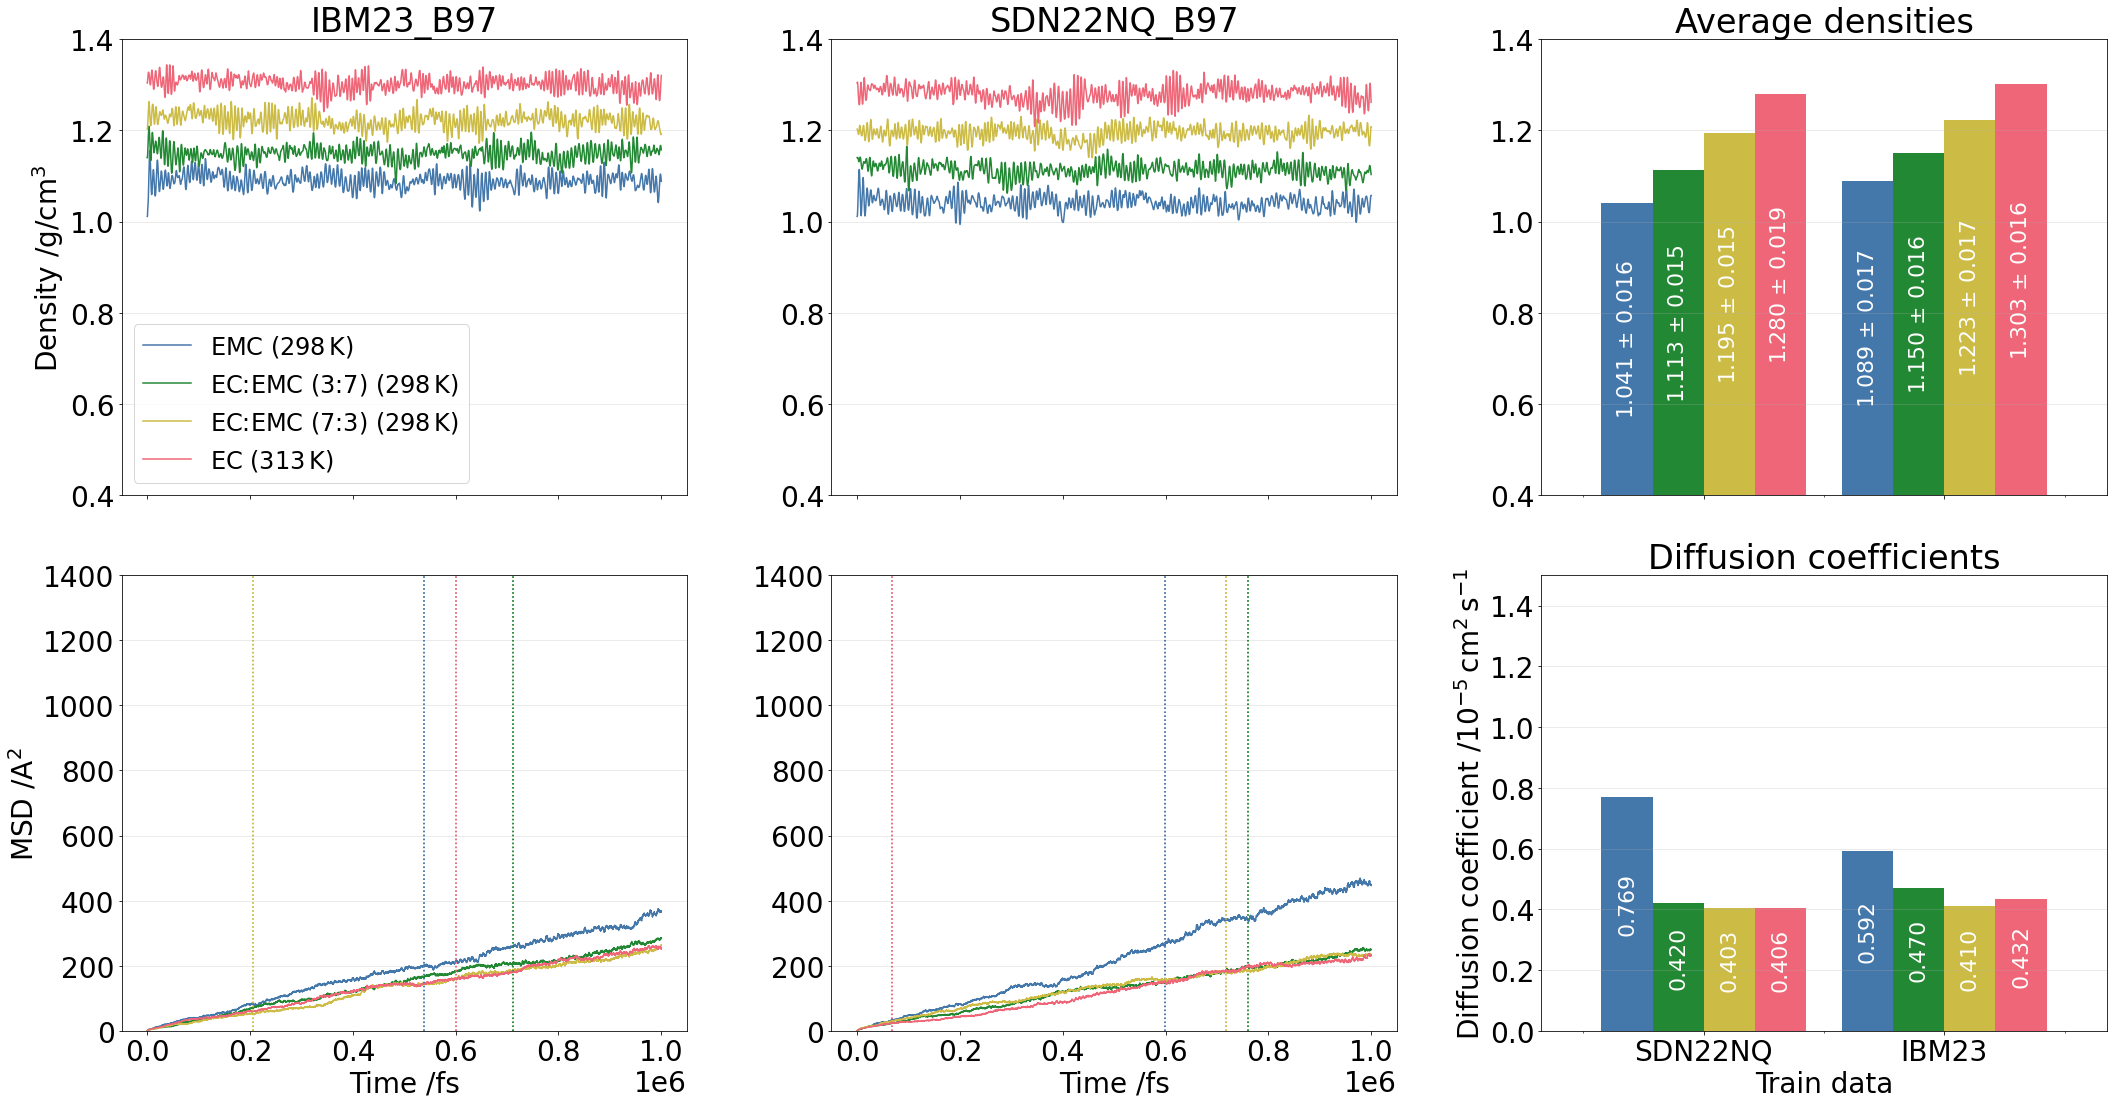

In [10]:
fsize = 28
plt.rcParams.update({'font.size': fsize})

order = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

# Pivot tables for plotting
avg_pivot_df = plot_df.pivot(
	index='Train data',
	columns='Composition',
	values='Avg. density',
).sort_index(axis=0,ascending=False)[order]

std_pivot_df = plot_df.pivot(
	index='Train data',
	columns='Composition',
	values='Std. density',
).sort_index(axis=0,ascending=False)[order]

diff_pivot_df = plot_df.pivot(
	index='Train data',
	columns='Composition',
	values='Diffusion coefficient',
	#values=['Avg. density', 'Var.'],
).sort_index(axis=0,ascending=False)[order]

fig, axs = plt.subplots(2,len(tags)+1, figsize=(10*(len(tags)+1), 8*2), sharex='col')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for j, (traj_name, traj_data) in enumerate(thermo[k].items()):
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']


        # Plot density
        axs[0,i].set_ylim([0.4, 1.4])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name], color=get_colour(traj_name))

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name], color=get_colour(traj_name))

        axs[1,0].axvline(plot_df['Diff. start time /ns'].iloc[j]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        axs[1,1].axvline(plot_df['Diff. start time /ns'].iloc[j+4]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
        #axs[1,2].axvline(paper_part2_df['Diff. start time /ns'].iloc[j+8]*1e6, 0, 1, color=get_colour(traj_name), alpha=1, linestyle='dotted')
      
        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
        axs[0,i].grid(axis='y', alpha=0.3)
        axs[1,i].grid(axis='y', alpha=0.3)

#axs[-1,-1].legend(loc='upper left')

axs[0,-1].set_title('Average densities')
a0 = avg_pivot_df.plot.bar(
    ylim=[0.4,1.4],
    xlabel='',
    #ylabel=f'Avg. density /{dunit}',
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[0,-1],
    legend=False,
)
#axs[0,-1].legend(loc='upper left', fontsize=18)
axs[0,-1].grid(axis='y', alpha=0.3)

axs[1,-1].set_title('Diffusion coefficients')
a1 = diff_pivot_df.plot.bar(
    ylim=[0,1.5],
    ylabel=f'Diffusion coefficient /$10^{{-5}}\\,\\text{{cm}}^2\\,\\text{{s}}^{{-1}}$',
    rot=0,
    width=0.85,
    color=[get_colour(o) for o in order],
    ax=axs[1,-1],
    legend=False,
)
#for c0,c1 in zip(a0.containers, a1.containers):
#    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)
#    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-4, label_type='edge', fmt='%.3f', padding=10)

for i, (c0,c1) in enumerate(zip(a0.containers, a1.containers)):
    col_name = avg_pivot_df.columns[i]
    dens_vals = avg_pivot_df[col_name]
    dens_errs = std_pivot_df[col_name]
    dens_labels = [f'{v:.3f} $\\pm$ {e:.3f}' for v, e in zip(dens_vals, dens_errs)]

    axs[0,-1].bar_label(c0, rotation=90, fontsize=fsize-6, label_type='center', padding=10, labels=dens_labels, color='white')
    axs[1,-1].bar_label(c1, rotation=90, fontsize=fsize-6, label_type='center', fmt='%.3f', padding=10, color='white')

axs[0,0].legend(loc='lower left', fontsize=fsize-4)
axs[1,-1].grid(axis='y', alpha=0.3)

#axs[0, 1].set(yticklabels=[]); axs[0, 2].set(yticklabels=[]); axs[0, 3].set(yticklabels=[])
#axs[1, 1].set(yticklabels=[]); axs[1, 2].set(yticklabels=[])

#plt.rcParams.update({'font.size': 16})
plt.tight_layout()

# Latex tables for paper

In [8]:
def train_data_density(df, functional, composition):
    comp_mask = df['Composition'] == composition
    train_mask = df['Train data'] == functional
    selection = df[comp_mask & train_mask]['Diffusion coefficient']
    return selection.iloc[0]


configs = [
    'EMC (298$\,$K)',
    'EC:EMC (3:7) (298$\,$K)', 
    'EC:EMC (7:3) (298$\,$K)',
    'EC (313$\,$K)',
]

data = {
    'Train data pair':['\IBM and \SD{NQ}'],
}

for config in configs:
    IBM23_dens = train_data_density(df, 'IBM23', config)
    SD22NQ_dens = train_data_density(df, 'SDN22NQ', config)
    data[config] = [abs(IBM23_dens-SD22NQ_dens)]
    print(config)
    print(f'Bulk-Cluster diff.: {abs(IBM23_dens-SD22NQ_dens):.4f} g/mL\n')

part2_dens_df = pd.DataFrame(data).round(decimals=3)
#part2_dens_df['Avg. deviations'] = part2_dens_df.sum(axis=1, numeric_only=True)/len(part2_dens_df.columns)
#part2_dens_df
print(part2_dens_df.to_latex(index=False))

EMC (298$\,$K)
Bulk-Cluster diff.: 0.1765 g/mL

EC:EMC (3:7) (298$\,$K)
Bulk-Cluster diff.: 0.0497 g/mL

EC:EMC (7:3) (298$\,$K)
Bulk-Cluster diff.: 0.0065 g/mL

EC (313$\,$K)
Bulk-Cluster diff.: 0.0265 g/mL

\begin{tabular}{lrrrr}
\toprule
Train data pair & EMC (298$\,$K) & EC:EMC (3:7) (298$\,$K) & EC:EMC (7:3) (298$\,$K) & EC (313$\,$K) \\
\midrule
\IBM and \SD{NQ} & 0.176000 & 0.050000 & 0.007000 & 0.027000 \\
\bottomrule
\end{tabular}



In [9]:
def train_data_diffusivity(df, functional, composition):
    comp_mask = df['Composition'] == composition
    train_mask = df['Train data'] == functional
    selection = df[comp_mask & train_mask]['Avg. density']
    return selection.iloc[0]

data = {
    'Train data pair':['\IBM and \SD{NQ}'],
}

for config in configs:
    IBM23_diff = train_data_diffusivity(df, 'IBM23', config)
    SD22NQ_diff = train_data_diffusivity(df, 'SDN22NQ', config)
    data[config] = [abs(IBM23_diff-SD22NQ_diff)]
    print(config)
    print(f'Bulk-Cluster diff.: {abs(IBM23_diff-SD22NQ_diff):.4f} g/mL\n')

part2_diff_df = pd.DataFrame(data).round(decimals=4)
#part2_dens_df['Avg. deviations'] = part2_dens_df.sum(axis=1, numeric_only=True)/len(part2_dens_df.columns)
#part2_dens_df
print(part2_diff_df.to_latex(index=False))

EMC (298$\,$K)
Bulk-Cluster diff.: 0.0486 g/mL

EC:EMC (3:7) (298$\,$K)
Bulk-Cluster diff.: 0.0368 g/mL

EC:EMC (7:3) (298$\,$K)
Bulk-Cluster diff.: 0.0281 g/mL

EC (313$\,$K)
Bulk-Cluster diff.: 0.0222 g/mL

\begin{tabular}{lrrrr}
\toprule
Train data pair & EMC (298$\,$K) & EC:EMC (3:7) (298$\,$K) & EC:EMC (7:3) (298$\,$K) & EC (313$\,$K) \\
\midrule
\IBM and \SD{NQ} & 0.048600 & 0.036800 & 0.028100 & 0.022200 \\
\bottomrule
\end{tabular}

